reference

- https://www.kaggle.com/code/andreynesterov/home-credit-baseline-data
- https://www.kaggle.com/code/andreynesterov/home-credit-baseline-training-lightautoml
- https://www.kaggle.com/code/greysky/home-credit-baseline

#### 패키지 설치 및 불러오기

In [1]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')

In [2]:
if __name__ == '__main__':
    pd.set_option('max_colwidth', 400)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 500)
    pd.reset_option("display.max_rows", 0)
    pd.set_option('max_colwidth', 50)

#### 데이터 수집 및 전처리

In [3]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        # 이미 데이터타입이 카테고리형이면 다음 반복으로 넘어가기
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # 만약 데이터타입이 object가 아니고, 앞 세글자가 int라면 (int8 ,int16, ...)
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  

            # 만약 데이터타입이 object가 아니고, 앞 세글자가 int가 아니라면 (float16, float32, ...)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)                    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
        # 데이터타입이 object라면 category으로 형변환
        else:
            df[col] = df[col].astype('category')

    # 형변환 이후의 데이터프레임의 메모리 사용량
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### 파이프라인

In [4]:
class Pipeline:
    # 각 column에 대해서 형변환을 해주는 정적메소드
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df

    # 'D' type의 날짜 데이터에 데이터가 수집된 날짜를 뺀다.
    # 해당 데이터를 날짜 간의 일(day) 단위로 계산된 결과로 변환한다.
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        # 결측치 비율이 95% 이상인 column 제거하기
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        # 문자열 타입에서 유일한 값이 단 하나거나, 200개 이상인 column 제거하기
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

#### 자동 집계

In [5]:
class Aggregator:
    # 생성자
    # 수치형 데이터: num_aggregators
    # 날짜형 데이터: num_aggregators 
    # (Pipeline / handle_dates 메소드로 인해 날짜를 수치적으로 다룰 수 있음)

    # 문자형 데이터: str_aggregators
    # 매개변수 str_mode=True 일 시, 최빈값 또한 측정

    # 기타 데이터(T, L): str_aggregators
    # num_group column: group_aggregators

    def __init__(
        self, 
        num_aggregators=[pl.max, pl.min, pl.first, pl.last, pl.mean], 
        str_aggregators=[pl.max, pl.min, pl.first, pl.last],  # n_unique
        group_aggregators=[pl.max, pl.min, pl.first, pl.last],
        str_mode=True
    ):
        self.num_aggregators = num_aggregators
        self.str_aggregators = str_aggregators
        self.group_aggregators = group_aggregators
        self.str_mode=str_mode
    
    def num_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("P", "A")]
        expr_all = []
        for method in self.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]
            expr_all += expr

        return expr_all

    def date_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("D",)]
        expr_all = []
        for method in self.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    def str_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("M",)]
        
        expr_all = []
        for method in self.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr
            
        if self.str_mode:
            expr_mode = [
                pl.col(col)
                .drop_nulls()
                .mode()
                .first()
                .alias(f"mode_{col}")
                for col in cols
            ]
        else:
            expr_mode = []

        return expr_all + expr_mode

    def other_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("T", "L")]
        
        expr_all = []
        for method in self.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all
    
    def count_expr(self, df_cols):
        cols = [col for col in df_cols if "num_group" in col]

        expr_all = []
        for method in self.group_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    def get_exprs(self, df_cols):
        exprs = (
            self.num_expr(df_cols) + 
            self.date_expr(df_cols) + 
            self.str_expr(df_cols) + 
            self.other_expr(df_cols) + 
            self.count_expr(df_cols)
        )

        return exprs

#### 파일 입출력

In [6]:
def read_file(path, aggregator=Aggregator(), depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)

    if depth in [1, 2]:
        df = df.group_by("case_id").agg(aggregator.get_exprs(df.columns))
    
    return df

def read_files(regex_path, aggregator=Aggregator(), agg_chunks=False, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunk = pl.read_parquet(path).pipe(Pipeline.set_table_dtypes)

        # agg_chunks 매개변수가 True라면
        if agg_chunks:
            chunk = chunk.group_by("case_id").agg(aggregator.get_exprs(chunk.columns))
        chunks.append(chunk)
    df = pl.concat(chunks, how="vertical_relaxed")
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(aggregator.get_exprs(df.columns))
    
    return df

    # agg_chunks가 True고 depth > 1이라면 여러 개의 데이터 파일이 있을 때, 각 파일(chunk)마다 집계하고
    # 집계한 데이터를 합쳐 다시 한번 집계한다.

    # 데이터 파일마다 집계 + 모아서 한 번 더 집계 vs 데이터 파일을 단순히 모은 후, 한번에 집계
    # 뭐가 더 좋을지는 회의 때 말해보자! ==> False!

#### 피처 엔지니어링

In [7]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data

In [8]:
def feature_eng(df_base, depth_0, depth_1, depth_2, mode='train', train_cols=[], cat_cols=None, convert_pandas=True):
    df_base = df_base.with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
    )

    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)

    if mode == "train":
        df_base = df_base.pipe(Pipeline.filter_cols)
        train_cols = df_base.columns
    else:
        train_cols = df_base.columns if len(train_cols) == 0 else train_cols
        df_base = df_base.select([col for col in train_cols if col != "target"])

    if convert_pandas:
        df_base = to_pandas(df_base, cat_cols)

    return df_base, train_cols

#### Configuration

In [9]:
class CONFIG:
    root_dir = Path("data")
    train_dir = Path("data/parquet_files/train")
    test_dir = Path("data/parquet_files/test")

In [10]:
# 각 데이터셋마다 특정한 aggregator 선택하기!
# 예시
'''
credit_b_a_1_agg = Aggregator(
    num_aggregators = [pl.max, pl.min, pl.first, pl.last, pl.mean],
    str_aggregators = [pl.max, pl.min, pl.first, pl.last], # n_unique
    group_aggregators = [pl.max, pl.min, pl.first, pl.last]
)
'''
if __name__ == '__main__':
    data_store = {
        "df_base": read_file(CONFIG.train_dir / "train_base.parquet"),
        "depth_0": [
            read_file(CONFIG.train_dir / "train_static_cb_0.parquet"),
            read_files(CONFIG.train_dir / "train_static_0_*.parquet"),
        ],
        "depth_1": [
            read_files(CONFIG.train_dir / "train_applprev_1_*.parquet", Aggregator(),1),
            read_file(CONFIG.train_dir / "train_tax_registry_a_1.parquet", Aggregator(),1),
            read_file(CONFIG.train_dir / "train_tax_registry_b_1.parquet", Aggregator(),1),
            read_file(CONFIG.train_dir / "train_tax_registry_c_1.parquet", Aggregator(),1),
            read_file(CONFIG.train_dir / "train_credit_bureau_b_1.parquet", Aggregator(),1),
            read_file(CONFIG.train_dir / "train_other_1.parquet", Aggregator(),1),
            read_file(CONFIG.train_dir / "train_person_1.parquet", Aggregator(),1),
            read_file(CONFIG.train_dir / "train_deposit_1.parquet", Aggregator(),1),
            read_file(CONFIG.train_dir / "train_debitcard_1.parquet", Aggregator(),1),
        ],
        "depth_2": [
            read_file(CONFIG.train_dir / "train_credit_bureau_b_2.parquet", Aggregator(),2),
        ]
    }

    df_train, train_cols = feature_eng(**data_store, mode='train', train_cols=[], cat_cols=None, convert_pandas=True)
    print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 516)


In [11]:
del data_store
gc.collect()

16

In [12]:
if __name__ == '__main__':
    data_store = {
        "df_base": read_file(CONFIG.test_dir / "test_base.parquet"),
        "depth_0": [
            read_file(CONFIG.test_dir / "test_static_cb_0.parquet"),
            read_files(CONFIG.test_dir / "test_static_0_*.parquet"),
        ],
        "depth_1": [
            read_files(CONFIG.test_dir / "test_applprev_1_*.parquet", Aggregator(),1),
            read_file(CONFIG.test_dir / "test_tax_registry_a_1.parquet", Aggregator(),1),
            read_file(CONFIG.test_dir / "test_tax_registry_b_1.parquet", Aggregator(),1),
            read_file(CONFIG.test_dir / "test_tax_registry_c_1.parquet", Aggregator(),1),
            read_file(CONFIG.test_dir / "test_credit_bureau_b_1.parquet", Aggregator(),1),
            read_file(CONFIG.test_dir / "test_other_1.parquet", Aggregator(),1),
            read_file(CONFIG.test_dir / "test_person_1.parquet", Aggregator(),1),
            read_file(CONFIG.test_dir / "test_deposit_1.parquet", Aggregator(),1),
            read_file(CONFIG.test_dir / "test_debitcard_1.parquet", Aggregator(),1),
        ],
        "depth_2": [
            read_file(CONFIG.test_dir / "test_credit_bureau_b_2.parquet", Aggregator(),2),
        ]
    }

    df_test, _ = feature_eng(**data_store, mode='test', train_cols=train_cols, cat_cols=None, convert_pandas=True)
    print("test data shape:\t", df_test.shape)

test data shape:	 (10, 515)


In [13]:
del data_store
gc.collect()

16

#### 현지님 데이터셋 병합하기

In [24]:
train_credit_bureau_a = pl.read_csv('hyeonji.csv')
df_train = df_train.join(train_credit_bureau_a, how='left', on='case_id', )
display(df_train)

del train_credit_bureau_a
gc.collect()

case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,…,overdueamountmaxdatemonth_365T_1,overdueamountmaxdatemonth_365T_10,overdueamountmaxdatemonth_365T_11,overdueamountmaxdatemonth_365T_12,overdueamountmaxdatemonth_365T_2,overdueamountmaxdatemonth_365T_3,overdueamountmaxdatemonth_365T_4,overdueamountmaxdatemonth_365T_5,overdueamountmaxdatemonth_365T_6,overdueamountmaxdatemonth_365T_7,overdueamountmaxdatemonth_365T_8,overdueamountmaxdatemonth_365T_9,overdueamountmaxdateyear_2T_0,overdueamountmaxdateyear_2T_2015,overdueamountmaxdateyear_2T_2016,overdueamountmaxdateyear_2T_2017,overdueamountmaxdateyear_2T_2018,overdueamountmaxdateyear_2T_2019,overdueamountmaxdateyear_2T_2020,overdueamountmaxdateyear_994T_0,overdueamountmaxdateyear_994T_2004,overdueamountmaxdateyear_994T_2005,overdueamountmaxdateyear_994T_2006,overdueamountmaxdateyear_994T_2007,overdueamountmaxdateyear_994T_2008,overdueamountmaxdateyear_994T_2009,overdueamountmaxdateyear_994T_2010,overdueamountmaxdateyear_994T_2011,overdueamountmaxdateyear_994T_2012,overdueamountmaxdateyear_994T_2013,overdueamountmaxdateyear_994T_2014,overdueamountmaxdateyear_994T_2015,overdueamountmaxdateyear_994T_2016,overdueamountmaxdateyear_994T_2017,overdueamountmaxdateyear_994T_2018,overdueamountmaxdateyear_994T_2019,overdueamountmaxdateyear_994T_2020
i64,i64,i64,i8,i8,i64,i64,i64,f64,i64,f64,f64,f64,f64,f64,str,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,str,i64,i64,i64,f64,f64,f64,f64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
0,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,0,0,1,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,0,1,1,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5,0,0,1,3,null,null,null,null,null,nu

0

In [ ]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

In [ ]:
df_train.info()

In [34]:
df_train.write_csv('df_train.csv')
df_test.write_csv('df_test.csv')

=========================
#### 데이터 불러오기

- 불러오고 난 후에는 문자열 타입이 다시 object이므로 category로 변환해주어야한다.

In [25]:
df_train = pd.read_csv('df_train.csv', index_col=0)
df_test = pd.read_csv('df_test.csv', index_col=0)

In [ ]:
# 데이터셋을 새로 불러왔을 때
cat_cols = list(df_train.select_dtypes("object").columns)
df_train[cat_cols] = df_train[cat_cols].astype("category")

cat_cols = list(df_test.select_dtypes("object").columns)
df_test[cat_cols] = df_test[cat_cols].astype("category")

In [12]:
display(df_train)
display(df_test)

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastinstal40dpd_247D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,equalitydataagreement_891L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,isdebitcard_729L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_60

case_id  WEEK_NUM  month_decision  weekday_decision  assignmentdate_238D  \
0    57543        92              10                 2                  NaN   
1    57549        92              10                 2                  NaN   
2    57551        92              10                 2                  NaN   
3    57552        92              10                 3                  NaN   
4    57569        92              10                 2                  NaN   
5    57630        92              10                 2                  NaN   
6    57631        92              10                 2                  NaN   
7    57632        92              10                 2                  NaN   
8    57633        92              10                 2                  NaN   
9    57634        92              10                 2                  NaN   

   assignmentdate_4527235D  assignmentdate_4955616D  birthdate_574D  \
0                      NaN                      NaN             NaN   
1                      NaN                      NaN             NaN   
2                      NaN                      NaN             NaN   
3                      NaN                  -3140.0             NaN   
4                      NaN                  -5590.0             NaN   
5                      NaN                      NaN             NaN   
6                      NaN                  -2734.0             NaN   
7                      NaN                  -1504.0             NaN   
8                      NaN                      NaN             NaN   
9                      NaN                  -1026.0             NaN   

   contractssum_5085716L  dateofbirth_337D  dateofbirth_342D  days120_123L  \
0               22130.26           -8830.0               NaN           9.0   
1                    NaN          -10450.0               NaN           0.0   
2                    NaN          -11020.0               NaN           2.0   
3                    NaN          -26300.0               NaN           0.0   
4                    NaN          -26400.0               NaN           0.0   
5                    NaN          -22190.0               NaN           0.0   
6              750875.44          -23970.0               NaN           6.0   
7                    NaN          -24540.0               NaN           0.0   
8                   0.00          -11176.0               NaN           1.0   
9                    NaN               NaN               NaN           NaN   

   days180_256L  days30_165L  days360_512L  days90_310L description_5085714M  \
0           9.0          9.0          10.0          9.0             2fc785b2   
1           0.0          0.0           0.0          0.0             2fc785b2   
2           2.0          1.0           2.0          2.0             2fc785b2   
3           0.0          0.0           0.0          0.0             2fc785b2   
4           0.0          0.0           0.0          0.0             2fc785b2   
5           0.0          0.0           0.0          0.0             2fc785b2   
6           7.0          1.0          12.0          1.0             2fc785b2   
7           0.0          0.0           0.0          0.0             2fc785b2   
8           1.0          1.0           2.0          1.0             2fc785b2   
9           NaN          NaN           NaN          NaN             a55475b1   

  education_1103M education_88M  firstquarter_103L  for3years_128L  \
0        a55475b1      a55475b1                4.0             NaN   
1        a55475b1      a55475b1                0.0             NaN   
2        a55475b1      a55475b1                0.0             NaN   
3        a55475b1      a55475b1                0.0             NaN   
4        a55475b1      a55475b1                0.0             NaN   
5        a55475b1      a55475b1                0.0             NaN   
6        a55475b1      a55475b1                6.0             NaN   
7        a55475b1      a55475b1                0.0 

#### 상관계수 분석

In [13]:
import itertools
from scipy.stats import chi2_contingency

class Correlation:

    def __init__(self, df):
        self.df = df
    
    def _cramers_v(self, var1, var2):
        # 교차표 생성
        contingency_table = pd.crosstab(self.df[var1], self.df[var2])

        # 교차표가 비어 있는 경우에는 크래머의 V 계수를 0으로 설정
        if contingency_table.empty:
            return 0

        # 카이제곱 통계량, p-value, 자유도, 기대도수 행렬 계산
        chi2, _, _, _ = chi2_contingency(contingency_table)

        # 크래머의 V 계수 계산
        n = self.df.shape[0]
        k = contingency_table.shape[0]
        r = contingency_table.shape[1]
        v = np.sqrt(chi2 / (n * max(1, min(k-1, r-1))))

        return v

    def cramers_v_correlation(self, print_plot=False):
        category_columns = self.df.select_dtypes(include='category').columns
        combinations = list(itertools.combinations(category_columns, 2))
        
        result = {}
        matrix = pd.DataFrame(index=category_columns, columns=category_columns)
        
        for combination in combinations:
            var1, var2 = combination
            v_coefficient = self._cramers_v(var1, var2)
            result[var1, var2] = v_coefficient

            # 행렬에 값 채우기
            matrix.loc[var1, var2] = v_coefficient
            matrix.loc[var2, var1] = v_coefficient

        # 히트맵 그리기
        if print_plot:
            sns.heatmap(matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Cramer\'s V Coefficient Heatmap')
            plt.show()

        return result
    
    def pearson_correlation(self, print_plot=False):
        numeric_columns = self.df.select_dtypes(include='number').columns
        correlation_matrix = self.df[numeric_columns].corr()

        # 히트맵 그리기
        if print_plot:
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
            plt.title('Pearson Correlation Coefficient Heatmap')
            plt.show()

        return correlation_matrix

In [14]:
# 맛보기 100개
co = Correlation(df_train.iloc[:, :100])
cramer = co.cramers_v_correlation()
pearson = co.pearson_correlation()

#### DROP COLUMNS

In [16]:
print(f'카테고리형 데이터의 상관계수가 0.5를 넘는 column 조합')
for col in cramer:
    if cramer[col] > 0.5:
        print(col, round(cramer[col], 2))

print()
print(f'수치형 데이터의 상관계수가 0.5 넘는 column 조합')
for row in pearson.index:
    for col in pearson.columns:
        if row != col:
            if abs(pearson.loc[row, col]) > 0.5:
                print((row, col), round(pearson.loc[row, col], 2))

카테고리형 데이터의 상관계수가 0.5를 넘는 column 조합
('credtype_322L', 'disbursementtype_67L') 0.77
('credtype_322L', 'inittransactioncode_186L') 0.77
('disbursementtype_67L', 'inittransactioncode_186L') 1.0

수치형 데이터의 상관계수가 0.5 넘는 column 조합
('case_id', 'isbidproduct_1095L') 0.61
('WEEK_NUM', 'pmtcount_4527229L') 0.53
('assignmentdate_238D', 'birthdate_574D') 0.61
('assignmentdate_4527235D', 'responsedate_1012D') 0.62
('assignmentdate_4527235D', 'responsedate_4527233D') 1.0
('birthdate_574D', 'assignmentdate_238D') 0.61
('birthdate_574D', 'dateofbirth_337D') 1.0
('dateofbirth_337D', 'birthdate_574D') 1.0
('days120_123L', 'days180_256L') 0.91
('days120_123L', 'days30_165L') 0.65
('days120_123L', 'days360_512L') 0.77
('days120_123L', 'days90_310L') 0.92
('days120_123L', 'numberofqueries_373L') 0.77
('days180_256L', 'days120_123L') 0.91
('days180_256L', 'days30_165L') 0.57
('days180_256L', 'days360_512L') 0.86
('days180_256L', 'days90_310L') 0.82
('days180_256L', 'firstquarter_103L') 0.56
('days180_256L', '

In [ ]:
'''
co = Correlation(df_train)
cramer = co.cramers_v_correlation()
pearson = co.pearson_correlation()

drop_cols = []

print(f'카테고리형 데이터의 상관계수가 0.5를 넘는 column 조합')
for col in cramer:
    if cramer[col] > 0.5:
        drop_cols.append(col)

print('--------------------------------------------------------------')
print(f'수치형 데이터의 상관계수가 0.5 넘는 column 조합')
for row in pearson.index:
    for col in pearson.columns:
        if row != col:
            if abs(pearson.loc[row, col]) > 0.5:
                drop_cols.append(col)

df_train = df_train.drop(columns=drop_cols)
'''

#### 다운 샘플링 (혜윤님)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.utils import resample

In [25]:
def compare_downsampling(params, ratio=None):
    X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
    y = df_train["target"]
    weeks = df_train["WEEK_NUM"]

    if ratio is not None:
        df_resampled = pd.concat([X, y], axis=1)
        df_majority = df_resampled[df_resampled["target"] == 0]
        df_minority = df_resampled[df_resampled["target"] == 1]
        df_majority_downsampled = resample(df_majority, replace=False, n_samples=int(len(df_minority) * ratio), random_state=42)
        df_downsampled = pd.concat([df_majority_downsampled, df_minority])

        X_downsampled = df_downsampled.drop(columns=["target"])
        y_downsampled = df_downsampled["target"]

        X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.4, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)

    gbm = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_valid,
        callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
    )
    lgb.plot_importance(gbm, max_num_features=5, importance_type='split', figsize=(6, 4))
    plt.show()

    print(f'The AUC score on the train set is: {roc_auc_score(y_train, gbm.predict(X_train, num_iteration=gbm.best_iteration))}') 
    print(f'The AUC score on the valid set is: {roc_auc_score(y_valid, gbm.predict(X_valid, num_iteration=gbm.best_iteration))}')
    print(f'The AUC score on the test set is: {roc_auc_score(y_test, gbm.predict(X_test, num_iteration=gbm.best_iteration))}')

In [26]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

In [18]:
gc.collect()

16

In [ ]:
# compare_downsampling(params)
# compare_downsampling(params, 5)
# compare_downsampling(params, 10)

#### 데이터셋 두개로 나누기 (데이터가 너무커서 한 번에 처리를 할 수 없음)

- 더 좋은 방법 찾아보기 (강사님한테 질문)

In [ ]:
# WEEK_NUM이 변화함에 따라 target을 예측해야한다.
# 따라서 데이터를 분할할 때, 각각의 데이터에서 모든 WEEK_NUM의 데이터를 가지고 있어야한다.
# 이를 위해서,

'''
cv = StratifiedGroupKFold(n_splits=3, shuffle=False)
for idx_train, idx_valid in cv.split(X, y, groups=weeks):
'''
# cv.split(X, y, groups=weeks) 이 방식을 사용하려고 한다.


from sklearn.model_selection import StratifiedGroupKFold

weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=2, shuffle=False)
for idx_1, idx_2 in cv.split(df_train.drop(columns=["target"]), df_train["target"], groups=weeks):
    data_1 = df_train.iloc[idx_1]
    data_2 = df_train.iloc[idx_2]

data_1


In [18]:
data_1.to_csv('dataset_1.csv')
data_2.to_csv('dataset_2.csv')

#### 데이터 불러오기

In [11]:
df_train_1 = pd.read_csv('dataset_1.csv', index_col=0)

cat_cols = list(df_train_1.select_dtypes("object").columns)
df_train_1[cat_cols] = df_train_1[cat_cols].astype("category")

df_train_1 = reduce_mem_usage(df_train_1)

Memory usage of dataframe is 3445.48 MB
Memory usage after optimization is: 1152.55 MB
Decreased by 66.5%


#### EDA

In [14]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max()))

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (92, 92)


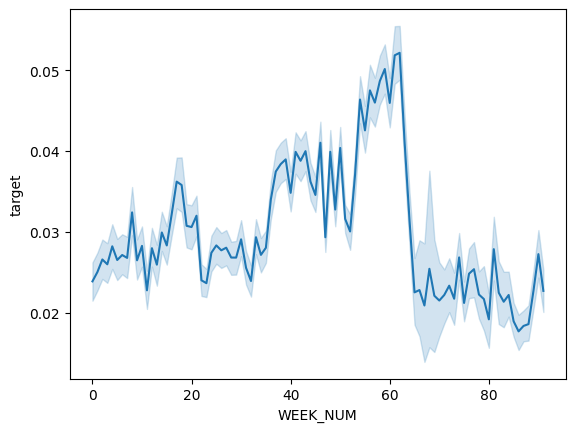

In [15]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

In [12]:
print("Train is duplicated:\t", df_train_1["case_id"].duplicated().any())
print("Train Week Range:\t", (df_train_1["WEEK_NUM"].min(), df_train_1["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)


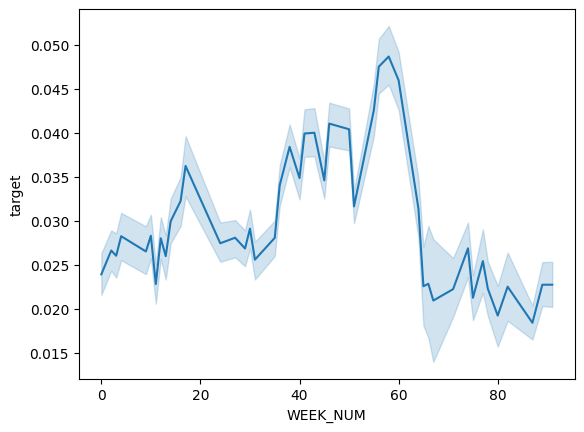

In [13]:
# 데이터를 나눴더니 target 경향이 달라진다.

sns.lineplot(
    data=df_train_1,
    x="WEEK_NUM",
    y="target",
)
plt.show()

#### 훈련하기

In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedGroupKFold
import lightgbm as lgb

class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

#### 모델 선정하기 

#### 하이퍼파라미터 튜닝하기

In [15]:
gc.collect()

16

In [ ]:
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.metrics import roc_auc_score 

# splitter.split에 사용되는 weeks
weeks = df_train["WEEK_NUM"]
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42)
split = splitter.split(df_train, groups=weeks)
train_idx, test_idx = next(split)

# 모든 정보가 들어있는 베이스 파일
train_base = df_train.iloc[train_idx]
test_base = df_train.iloc[test_idx]

# StratifiedGroupKFold.split에 사용되는 weeks
X = train_base.drop(columns=["target", "case_id", "WEEK_NUM"])
y = train_base["target"]
weeks = train_base["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    # "device": "gpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.821791
[200]	valid_0's auc: 0.83061
[300]	valid_0's auc: 0.833605
[400]	valid_0's auc: 0.834308
[500]	valid_0's auc: 0.83487
[600]	valid_0's auc: 0.835053
[700]	valid_0's auc: 0.835214
[800]	valid_0's auc: 0.835135
Early stopping, best iteration is:
[702]	valid_0's auc: 0.835231
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.820593
[200]	valid_0's auc: 0.828662
[300]	valid_0's auc: 0.831444
[400]	valid_0's auc: 0.832383
[500]	valid_0's auc: 0.832782
[600]	valid_0's auc: 0.832948
[700]	valid_0's auc: 0.833155
[800]	valid_0's auc: 0.833288
Early stopping, best iteration is:
[772]	valid_0's auc: 0.833396
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.816443
[200]	valid_0's auc: 0.825215
[300]	valid_0's auc: 0.827929
[400]	valid_0's auc: 0.828567
[500]	valid_0's auc: 0.828983
[600]	valid_0's auc: 0.829199
[700]	valid_0's auc: 0.829

In [33]:
import joblib

# 모델 저장
joblib.dump(model, 'model_lgbm.pkl')

['model_lgbm.pkl']

In [34]:
gc.collect()

16

In [16]:
import joblib
from sklearn.model_selection import GroupShuffleSplit 
from sklearn.metrics import roc_auc_score 

# 모델 불러오기
model = joblib.load('model_lgbm.pkl')

# splitter.split에 사용되는 weeks
weeks = df_train["WEEK_NUM"]
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 42)
split = splitter.split(df_train, groups=weeks)
train_idx, test_idx = next(split)

# 모든 정보가 들어있는 베이스 파일
train_base = df_train.iloc[train_idx]
test_base = df_train.iloc[test_idx]

In [17]:
X_train = train_base.drop(columns=["WEEK_NUM"])
X_train = X_train.set_index("case_id")
y_pred_train = pd.Series(model.predict_proba(X_train.iloc[:, 1:])[:, 1], index=X_train.index)

X_test = test_base.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")
y_pred_test = pd.Series(model.predict_proba(X_test.iloc[:, 1:])[:, 1], index=X_test.index)

X_train['score'] = y_pred_train
X_test['score'] = y_pred_test

In [18]:
print(f"The AUC score on the train set is: {roc_auc_score(train_base['target'], X_train['score'])}")
print(f"The AUC score on the test set is: {roc_auc_score(test_base['target'], X_test['score'])}")

The AUC score on the train set is: 0.9013961462593885
The AUC score on the test set is: 0.8332167206169545


In [20]:
X_train['WEEK_NUM'] = train_base["WEEK_NUM"]
X_test['WEEK_NUM'] = test_base["WEEK_NUM"]

In [21]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(X_train)
stability_score_test = gini_stability(X_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the test set is: {stability_score_test}')

The stability score on the train set is: 0.7500976226758336
The stability score on the test set is: 0.5258606681706502


#### 제출

In [22]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)
y_pred

case_id
57543    0.125744
57549    0.095589
57551    0.078877
57552    0.062982
57569    0.056887
57630    0.055349
57631    0.083771
57632    0.061790
57633    0.059324
57634    0.087003
dtype: float64

In [23]:
df_subm = pd.read_csv(CONFIG.root_dir / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [24]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.125744
57549,0.095589
57551,0.078877
57552,0.062982
57569,0.056887


In [ ]:
df_subm.to_csv("submission.csv")